# TabNet example classification for Forest Cover dataset

This notebook shows 
  - a simple workflow using TabNet for classification of the [Forest Cover](https://archive.ics.uci.edu/ml/datasets/covertype) (multi-classification) dataset
  - how to get global feature importances from the model
  - how to show local feature importances (masks) from the model
  - a comparison to XGBoost and LightGBM


In [1]:
try:
  from pytorch_tabnet.tab_model import TabNetClassifier
except:
  !pip install pytorch-tabnet
  from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
try:
  import wget
except:
  !pip install wget
  import wget

In [3]:
import torch; print('torch: ', torch.__version__)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd; print('pandas:', pd.__version__)
import numpy as np
np.random.seed(0)

import os
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

torch:  1.5.1+cu101
pandas: 1.0.5


In [4]:
!nvidia-smi

Mon Jul 27 11:04:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download ForestCoverType dataset


In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [6]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file as", tmp_out, "...")
    wget.download(url, tmp_out.as_posix())
    print("Extracting data to", out)
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

File already exists.


# Load data and split
Same split as in original paper

In [7]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4",
    "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4", "Soil_Type5",
    "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9", "Soil_Type10",
    "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14", "Soil_Type15",
    "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19", "Soil_Type20",
    "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24", "Soil_Type25",
    "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29", "Soil_Type30",
    "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34", "Soil_Type35",
    "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39", "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

columns = int_columns + bool_columns + [target]

In [8]:
train = pd.read_csv(out, header=None, names=columns)
print('loaded data with shape', train.shape, '\n')

print('target distribution:')
train[target].value_counts()

loaded data with shape (581012, 55) 

target distribution:


2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Covertype, dtype: int64

In [9]:
low_resource_run = True

if low_resource_run:
  train = train.head(32768)

In [10]:
# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

n_total = len(train)

train_val_indices, test_indices = train_test_split(range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices    = train_test_split(train_val_indices, test_size=0.2 / 0.6, random_state=0)

In [11]:
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Covertype
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [12]:
columns = pd.DataFrame({'column':train.columns})
columns['dtype']   = train.dtypes.values
columns['nunique'] = train.nunique().values
columns['missing'] = train.isnull().sum().values
columns

,column,dtype,nunique,missing
0,Elevation,int64,1665,0
1,Aspect,int64,361,0
2,Slope,int64,60,0
3,Horizontal_Distance_To_Hydrology,int64,400,0
4,Vertical_Distance_To_Hydrology,int64,425,0
5,Horizontal_Distance_To_Roadways,int64,5637,0
6,Hillshade_9am,int64,176,0
7,Hillshade_Noon,int64,141,0
8,Hillshade_3pm,int64,247,0
9,Horizontal_Distance_To_Fire_Points,int64,5692,0


# Preprocessing



There are no rows with missing data. All categories are already one-hot encoded.

All columns are already numeric and continuous or boolean - no categorical encoding required.

# Splits

In [13]:
exclude = ['Covertype']

In [14]:
features_all = [col for col in train.select_dtypes('number') if col not in exclude]
print(features_all)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


In [15]:
#if not os.getenv("CI", False):
X_train = train[features_all].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features_all].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features_all].values[test_indices]
y_test = train[target].values[test_indices]

print('train:', X_train.shape, '| valid:', X_valid.shape, '| test:', X_test.shape)

train: (17475, 54) | valid: (8739, 54) | test: (6554, 54)


# TabNet

In [16]:
clf = TabNetClassifier( 
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=[],
    cat_dims=[],
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,  
    #optimizer_params=dict(lr=2e-2),
    scheduler_params={"gamma": 0.95, "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cuda


## Training

In [17]:
batch_size = 1024 if low_resource_run else 16384 # only uses 32k rows in dataset

# takes abot 260s on a 2 core CPU (Google Colab)
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=1000, patience=10,
    batch_size=batch_size, 
    virtual_batch_size=128
)

print('best score:', -clf.best_cost)

Will train until validation stopping metric hasn't improved in 10 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.52858 |  0.37865 |   2.4       
| 2     | 0.62094 |  0.45245 |   4.6       
| 3     | 0.65459 |  0.52065 |   6.9       
| 4     | 0.66300 |  0.49640 |   9.1       
| 5     | 0.68778 |  0.56734 |   11.4      
| 6     | 0.69860 |  0.43563 |   13.7      
| 7     | 0.70403 |  0.55006 |   15.9      
| 8     | 0.70489 |  0.61483 |   18.2      
| 9     | 0.72177 |  0.58966 |   20.4      
| 10    | 0.71285 |  0.62009 |   22.7      
| 11    | 0.72057 |  0.65408 |   24.9      
| 12    | 0.72372 |  0.66999 |   27.2      
| 13    | 0.73642 |  0.69424 |   29.5      
| 14    | 0.72847 |  0.68498 |   31.7      
| 15    | 0.73373 |  0.71427 |   34.0      
| 16    | 0.74649 |  0.71782 |   36.2      
| 17    | 0.74993 |  0.71461 |   38.5      
| 18    | 0.74518 |  0.73830 |   40.7      
| 19    | 0.75891 |  0.74356 |   42.9      
| 20

In [18]:
# all rows: 166 epochs, 3042s, best score: 0.9441
# 32k rows: 114 epochs, 262s,  best score: 0.8660

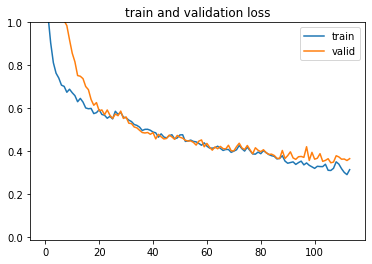

In [19]:
# plot losses
plt.plot(clf.history['train']['loss'], label='train')
plt.plot(clf.history['valid']['loss'], label='valid')
plt.ylim(None, 1)
plt.title('train and validation loss');
plt.legend();

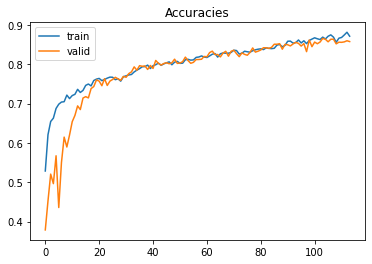

In [20]:
# plot accuracies
plt.title('Accuracies')
plt.plot([-x for x in clf.history['train']['metric']], label='train')
plt.plot([-x for x in clf.history['valid']['metric']], label='valid')
plt.legend();

## Predictions


In [21]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {-clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.8660029751687837
FINAL TEST SCORE FOR forest-cover-type : 0.8603906011595972


In [22]:
# or you can simply use the predict method
y_pred = clf.predict(X_test)
tabnet_test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {tabnet_test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.8603906011595972


## Save and load Model

In [23]:
# # save state dict
# saved_filename = clf.save_model('test_model')

In [24]:
# # define new model and load save parameters
# loaded_clf = TabNetClassifier()
# loaded_clf.load_model(saved_filename)

In [25]:
# loaded_preds = loaded_clf.predict_proba(X_test)
# loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

# loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

# print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

In [26]:
# assert(test_acc == loaded_test_acc)

## Global explainability : feat importance summing to 1

In [27]:
feat_imp = (pd.DataFrame({'feature':features_all,
                          'importance':np.round(clf.feature_importances_, 4)})
            .sort_values('importance', ascending=False)
            .reset_index(drop=True)
)
feat_imp.style.bar()

,feature,importance
0,Horizontal_Distance_To_Fire_Points,0.209600
1,Horizontal_Distance_To_Roadways,0.115000
2,Wilderness_Area4,0.114400
3,Soil_Type29,0.086200
4,Wilderness_Area3,0.049300
5,Vertical_Distance_To_Hydrology,0.047100
6,Elevation,0.043900
7,Wilderness_Area1,0.039300
8,Soil_Type33,0.028000
9,Soil_Type36,0.027300


## Local explainability and masks

In [28]:
explain_matrix, masks = clf.explain(X_test)

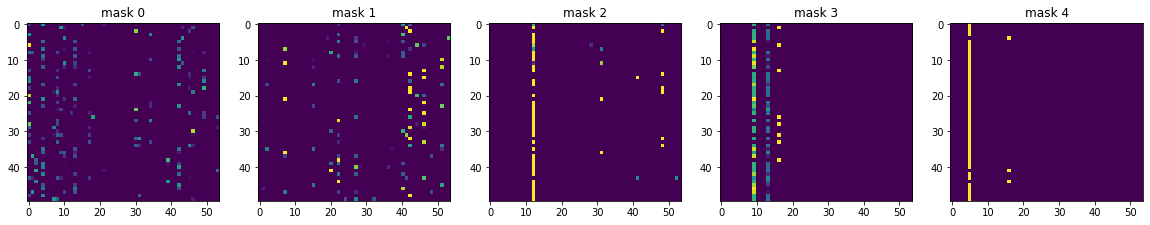

In [29]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# Comparison to XGBoost and LightGBM

## XGBoost

In [30]:
from xgboost import XGBClassifier

In [31]:
%%time
# create XGB Classifier with slightly adjusted values (defaults are underfitting too much)
# takes about 120s
clf_xgb = XGBClassifier(
    max_depth=7, learning_rate=0.1, n_estimators=1000,
    verbosity=0, silent=None, subsample=0.7,
    objective="multi:softmax", booster='gbtree',
    random_state=0, seed=None)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20,
            verbose=25)

[0]	validation_0-merror:0.187321
Will train until validation_0-merror hasn't improved in 20 rounds.
[25]	validation_0-merror:0.136972
[50]	validation_0-merror:0.117061
[75]	validation_0-merror:0.107335
[100]	validation_0-merror:0.101156
[125]	validation_0-merror:0.09635
[150]	validation_0-merror:0.09223
[175]	validation_0-merror:0.090171
[200]	validation_0-merror:0.087882
[225]	validation_0-merror:0.086165
[250]	validation_0-merror:0.085479
[275]	validation_0-merror:0.085708
[300]	validation_0-merror:0.084335
Stopping. Best iteration:
[299]	validation_0-merror:0.084335

CPU times: user 2min 6s, sys: 225 ms, total: 2min 6s
Wall time: 2min 6s


In [32]:
xgb_preds_test = clf_xgb.predict(X_test)
xgb_test_acc = accuracy_score(y_pred=xgb_preds_test, y_true=y_test)
print(f'XGBoost accuracy: {xgb_test_acc:.4f}')

XGBoost accuracy: 0.9132


## LightGBM

In [33]:
from lightgbm import LGBMClassifier

In [34]:
%%time
# LGBMClassifier with similar parameters to XGBoost
# takes about 20s
clf_lgb = LGBMClassifier(max_depth=7, learning_rate=0.1, 
                         n_estimators=5000, subsample=0.7, 
                         objective="multi_softmax",
                         random_stage=42)

clf_lgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], #eval_metric=['accuracy'],
            early_stopping_rounds=20,
            verbose=25);

Training until validation scores don't improve for 20 rounds.
[25]	valid_0's multi_logloss: 0.473933
[50]	valid_0's multi_logloss: 0.358571
[75]	valid_0's multi_logloss: 0.321053
[100]	valid_0's multi_logloss: 0.300877
[125]	valid_0's multi_logloss: 0.286505
[150]	valid_0's multi_logloss: 0.275008
[175]	valid_0's multi_logloss: 0.266141
[200]	valid_0's multi_logloss: 0.260322
[225]	valid_0's multi_logloss: 0.253281
[250]	valid_0's multi_logloss: 0.249375
[275]	valid_0's multi_logloss: 0.245908
[300]	valid_0's multi_logloss: 0.243972
[325]	valid_0's multi_logloss: 0.24308
Early stopping, best iteration is:
[320]	valid_0's multi_logloss: 0.242969
CPU times: user 9.09 s, sys: 143 ms, total: 9.23 s
Wall time: 9.22 s


In [35]:
lgb_preds_test = clf_lgb.predict(X_test)
lgb_test_acc = accuracy_score(y_pred=lgb_preds_test, y_true=y_test)
print(f'LightGBM accuracy: {lgb_test_acc:.4f}')

LightGBM accuracy: 0.9103


## all models

In [36]:
print('test accuracies:')
print(f'TabNet:   {tabnet_test_acc:.4f}')
print(f'XGBoost:  {xgb_test_acc:.4f}')
print(f'LightGBM: {lgb_test_acc:.4f}')

test accuracies:
TabNet:   0.8604
XGBoost:  0.9132
LightGBM: 0.9103


In [37]:
feat_imp = (pd.DataFrame({'feature':features_all
                          ,'importance_tabnet':np.round(clf.feature_importances_, 4)
                          ,'importance_xgb':   np.round(clf_xgb.feature_importances_, 4)
                          ,'importance_lgb':   np.round(clf_lgb.feature_importances_, 4)
                          })
            .sort_values('importance_tabnet', ascending=False)
            .reset_index(drop=True)
)
feat_imp.style.bar()

,feature,importance_tabnet,importance_xgb,importance_lgb
0,Horizontal_Distance_To_Fire_Points,0.209600,0.009300,9796
1,Horizontal_Distance_To_Roadways,0.115000,0.008700,9498
2,Wilderness_Area4,0.114400,0.064700,293
3,Soil_Type29,0.086200,0.008700,264
4,Wilderness_Area3,0.049300,0.024900,493
5,Vertical_Distance_To_Hydrology,0.047100,0.006800,5949
6,Elevation,0.043900,0.032300,9911
7,Wilderness_Area1,0.039300,0.372000,480
8,Soil_Type33,0.028000,0.006100,216
9,Soil_Type36,0.027300,0.006100,0
